In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from tqdm import tqdm
import gc
from scipy import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.linear_model import Ridge

In [2]:
def split_cat(text):
    try:
        return text.split("/")
    except:
        return ("No Label", "No Label", "No Label")

In [3]:
train = pd.read_csv('./train.tsv', sep='\t', 
                      dtype={'item_condition_id': 'category', 'shipping': 'category'}, 
                      converters={'category_name': split_cat})
test = pd.read_csv('./test.tsv', sep='\t', 
                     dtype={'item_condition_id': 'category', 'shipping': 'category'}, 
                     converters={'category_name': split_cat})

In [5]:
print('Shape of train data: ', train.shape)
print('Shape of test data: ', test.shape)
test[test.id == 17]

Shape of train data:  (1037774, 8)
Shape of test data:  (444761, 7)


,id,name,item_condition_id,category_name,brand_name,shipping,item_description
87057,17,New: Baby K'tan active baby carrier,1,"[Kids, Gear, Backpacks & Carriers]",NaN,1,Brand new in box Size: Medium Color: Coral Ret...


In [50]:
train[train.train_id == 8]

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,gencat_name,subcat1_name,subcat2_name
92985,8,Girls Nike Pro shorts,3,Nike,19.0,0,Girls Size small Plus green. Three shorts total.,SportsOutdoors,Apparel,Girls


In [14]:
train.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool

In [15]:
test.isnull().any()

id                   False
name                 False
item_condition_id    False
category_name        False
brand_name            True
shipping             False
item_description      True
dtype: bool

In [6]:
# Split category_name by '/' into subcategories and replace nulls with 'missing'
train['gencat_name'] = train['category_name'].str.get(0).replace('', 'missing').astype('category')
train['subcat1_name'] = train['category_name'].str.get(1).fillna('missing').astype('category')
train['subcat2_name'] = train['category_name'].str.get(2).fillna('missing').astype('category')
train.drop('category_name', axis=1, inplace=True)

# Split category_name by '/' into subcategories and replace nulls with 'missing'
test['gencat_name'] = test['category_name'].str.get(0).replace('', 'missing').astype('category')
test['subcat1_name'] = test['category_name'].str.get(1).fillna('missing').astype('category')
test['subcat2_name'] = test['category_name'].str.get(2).fillna('missing').astype('category')
test.drop('category_name', axis=1, inplace=True)

train['item_description'].fillna('missing', inplace=True)
train['brand_name'] = train['brand_name'].fillna('missing').astype('category')

test['item_description'].fillna('missing', inplace=True)
test['brand_name'] = test['brand_name'].fillna('missing').astype('category')

In [6]:
train[train.duplicated()] #Check for duplicate rows, NAs

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,gencat_name,subcat1_name,subcat2_name


In [7]:
print('Removed {} rows' .format(len(train[train.price<=0])))
train = train[train.price > 0].reset_index(drop=True)


Removed 604 rows


In [19]:
train.name.describe()

count     1037170
unique     877408
top        Bundle
freq         1553
Name: name, dtype: object

In [20]:
train.item_condition_id.describe()

count     1037170
unique          5
top             1
freq       448197
Name: item_condition_id, dtype: object

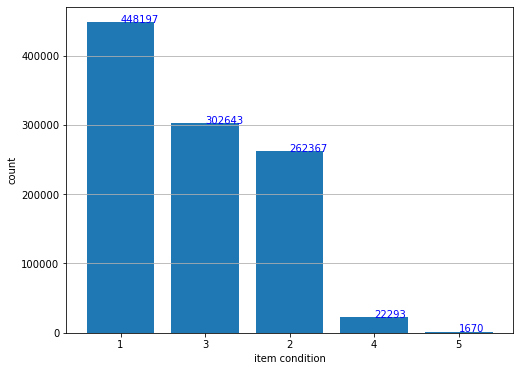

In [21]:
condition_count = Counter(list(train.item_condition_id))
x, y = zip(*condition_count.most_common())
plt.figure(figsize=[8,6])
plt.bar(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (x[i], y[i]), color='b')
plt.xlabel('item condition')
plt.ylabel('count')
plt.grid(True, axis='y')
plt.show()

In [22]:
train.brand_name.describe()

count     1037170
unique       4413
top       missing
freq       442715
Name: brand_name, dtype: object

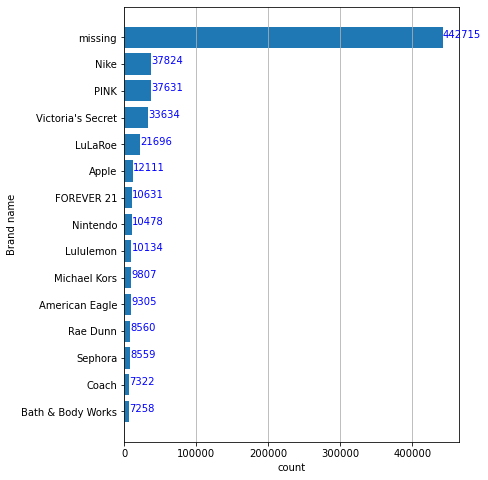

In [23]:
brand_count = Counter(list(train.brand_name.values))
x, y = zip(*brand_count.most_common(15))

plt.figure(figsize=[6,8])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.ylabel('Brand name')
plt.xlabel('count')
plt.grid(True, axis='x')
plt.show()

In [24]:
brand_missing = train[train.brand_name=='missing'].shape[0]
print('Brand name is missing for {} datapoints, i.e. {:.2f} % of train data.' .format(brand_missing, 100.0*brand_missing/train.shape[0]))

Brand name is missing for 442715 datapoints, i.e. 42.68 % of train data.


In [25]:
train.gencat_name.describe()

count     1037170
unique         11
top         Women
freq       464350
Name: gencat_name, dtype: object

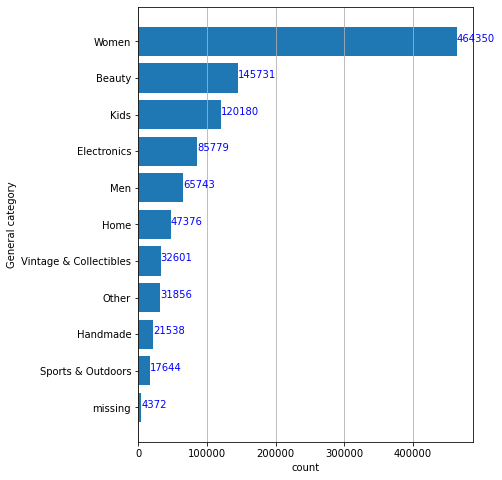

In [26]:
gencat_count = Counter(list(train.gencat_name.values))
x, y = zip(*gencat_count.most_common(15))
plt.figure(figsize=[6,8])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.ylabel('General category')
plt.xlabel('count')
plt.grid(True, axis='x')
plt.show()

In [27]:
gencat_missing = train[train.gencat_name=='missing'].shape[0]
print('category name is missing for {} datapoints, i.e. {:.2f} % of train data.' .format(gencat_missing, 100.0*gencat_missing/train.shape[0]))

category name is missing for 4372 datapoints, i.e. 0.42 % of train data.


In [28]:
train.subcat1_name.describe()

count              1037170
unique                 114
top       Athletic Apparel
freq                 93933
Name: subcat1_name, dtype: object

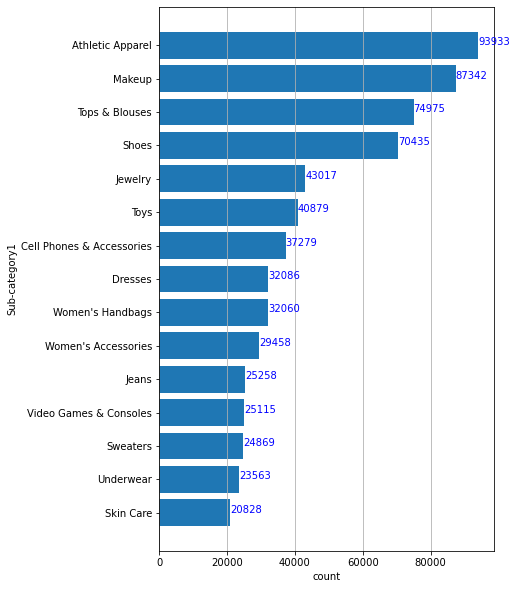

In [29]:
subcat1_count = Counter(list(train.subcat1_name.values))
x, y = zip(*subcat1_count.most_common(15))
plt.figure(figsize=[6,10])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.ylabel('Sub-category1')
plt.xlabel('count')
plt.grid(True, axis='x')
plt.show()

In [30]:
train.subcat2_name.describe()

count                     1037170
unique                        857
top       Pants, Tights, Leggings
freq                        42032
Name: subcat2_name, dtype: object

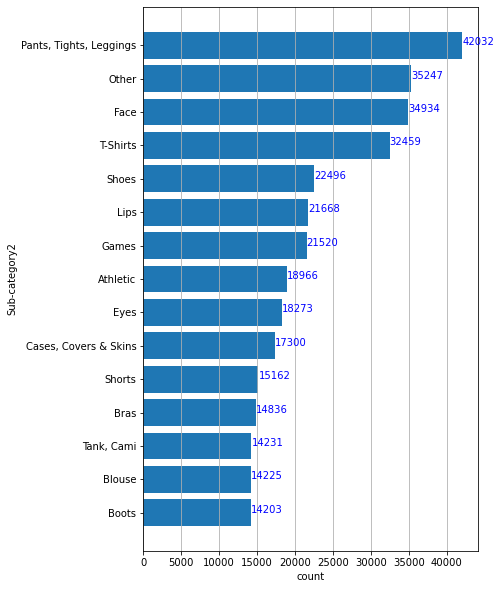

In [31]:
subcat2_count = Counter(list(train.subcat2_name.values))
x, y = zip(*subcat2_count.most_common(15))
plt.figure(figsize=[6,10])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.ylabel('Sub-category2')
plt.xlabel('count')
plt.grid(True, axis='x')
plt.show()

In [8]:
desc_missing = train[train.item_description=='missing'].shape[0]
print('item description is missing for {} datapoints, i.e. {:.5f} % of train data.' .format(desc_missing, 100.0*desc_missing/train.shape[0]))

item description is missing for 2 datapoints, i.e. 0.00019 % of train data.


In [9]:
train[train.item_description=='missing']

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,gencat_name,subcat1_name,subcat2_name
61467,1224924,Disney Minnie Head band,3,Disney,9.0,0,missing,Women,Women's Accessories,Hair Accessories
589297,1264242,For Bianca,3,missing,10.0,1,missing,Women,Women's Accessories,Scarves & Wraps


In [34]:
train.price.describe()

count    1.037170e+06
mean     2.675051e+01
std      3.862636e+01
min      3.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.004000e+03
Name: price, dtype: float64

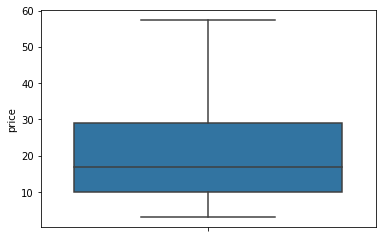

In [35]:
sns.boxplot(y='price', data=train, showfliers=False)
plt.show()

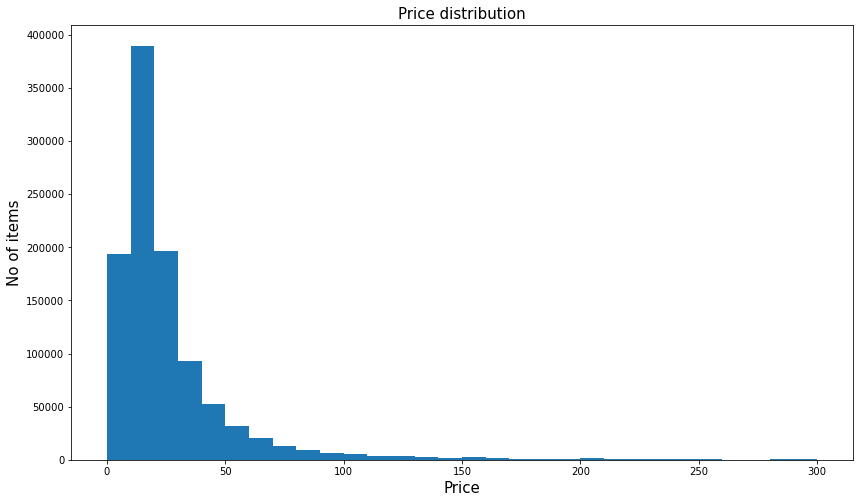

In [36]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.hist(train.price, bins=30, range=[0, 300], label="Price")
plt.title('Price distribution', fontsize = 15)
ax.set_xlabel('Price', fontsize=15)
ax.set_ylabel('No of items', fontsize=15)
plt.show()

In [10]:
def clean_cat(cat_values):
    
    catogories = list(cat_values)

    cat_list = []
    for i in (catogories):
        i = re.sub('[^A-Za-z0-9]+', ' ', i)
        i = i.replace(' ','')
        i = i.replace('&','_')
        cat_list.append(i.strip())
    
    return cat_list

In [11]:
train['gencat_name'] = clean_cat(train['gencat_name'].values)
test['gencat_name'] = clean_cat(test['gencat_name'].values)

train['subcat1_name'] = clean_cat(train['subcat1_name'].values)
test['subcat1_name'] = clean_cat(test['subcat1_name'].values)

train['subcat2_name'] = clean_cat(train['subcat2_name'].values)
test['subcat2_name'] = clean_cat(test['subcat2_name'].values)

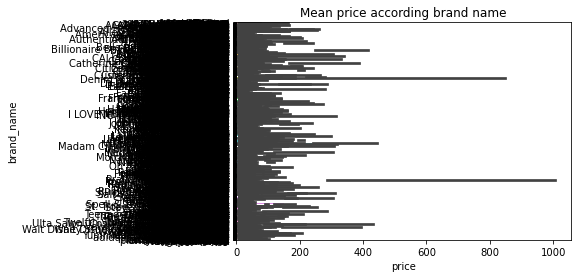

In [39]:
sns.barplot(y='brand_name', x='price', data=train)
plt.title('Mean price according brand name')
plt.show()

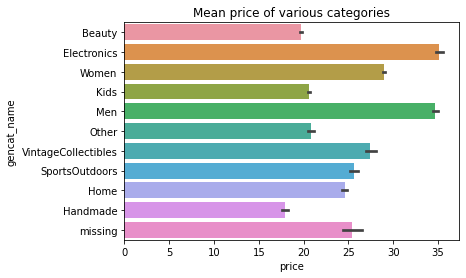

In [40]:
sns.barplot(y='gencat_name', x='price', data=train)
plt.title('Mean price of various categories')
plt.show()

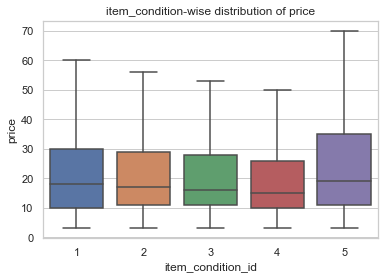

In [41]:
sns.set(style='whitegrid')
sns.boxplot(x='item_condition_id', y='price', data=train, showfliers=False)
plt.title('item_condition-wise distribution of price')
plt.show()

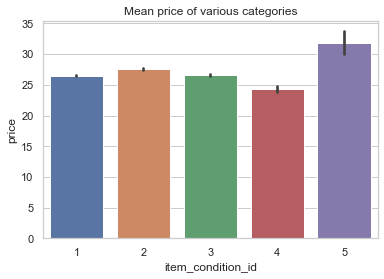

In [42]:
sns.barplot(y='price', x='item_condition_id', data=train)
plt.title('Mean price of various categories')
plt.show()

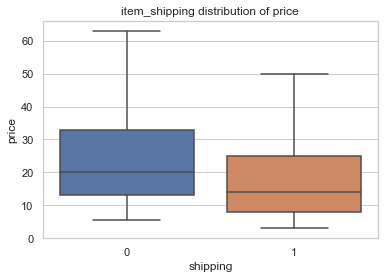

In [43]:
sns.set(style='whitegrid')
sns.boxplot(x='shipping', y='price', data=train, showfliers=False)
plt.title('item_shipping distribution of price')
plt.show()

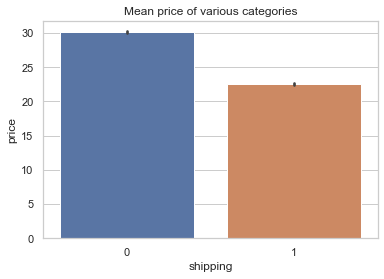

In [51]:
sns.barplot(y='price', x='shipping', data=train)
plt.title('Mean price of various categories')
plt.show()

In [12]:
train['name'].str.lower()

0          tarte rainforest after dark colored clay
1                        mac mineralize skin finish
2                            white case iphone 6/6s
3                  victoria's secret push-up plunge
4             disney princess toddler boots size 10
                             ...                   
1037165                     nike dri fit hooded top
1037166                       talk red hunter boots
1037167     nwt free ship cc 2beanie hat beige+taup
1037168                        winston cup snapback
1037169           old navy rockstar skinny cords 10
Name: name, Length: 1037170, dtype: object

In [13]:
test['name'].str.lower()

0                       herschel retreat backpack
1                               2 pairs of lebron
2          mario kart double dash with bonus disc
3          tokidoki unicorno kaiju and strawberry
4              like ugg cardy, grey knit top boot
                           ...                   
444756                         ivory ella tie dye
444757                      5 tier shoe organizer
444758    toy bundle (fun fun fun fun fun 4 baby)
444759                        adidas jogging suit
444760                           artistry hydra-v
Name: name, Length: 444761, dtype: object

In [14]:
test['item_description'].str.lower()
test['item_description'].str.lower()

0         in great condition! only issue is magnet that ...
1         lebron soldier 10 size 10.5 9/10 condition leb...
2                                good shape work no problem
3                               both new with foil and box.
4         brand new, not even a foot near them! size 8 b...
                                ...                        
444756    tags- american eagle, aeropostale, hollister, ...
444757    5 tier shoe organizer brand new never used 100...
444758    includes: fisher-price cozy fit tummy wedge ~ ...
444759    women comfortable adidas 2pc jogging suit incl...
444760                         full and great for your skin
Name: item_description, Length: 444761, dtype: object

In [15]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')


def preprocess_text(text_col):
    preprocessed_text = []
    for sentence in tqdm((text_col.values)):
        sent = sentence.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [16]:
train['preprocessed_name'] = preprocess_text(train['name'])
test['preprocessed_name'] = preprocess_text(test['name'])

train['preprocessed_description'] = preprocess_text(train['item_description'])
test['preprocessed_description'] = preprocess_text(test['item_description'])

100%|███████████████████████████████████████████████████████████████████████| 444761/444761 [00:42<00:00, 10398.88it/s]


In [17]:
train['name_len'] = train['name'].apply(lambda x: len(x))
train['des_len'] = train['item_description'].apply(lambda x: len(x))
train['desc_word_count'] = train['item_description'].apply(lambda x: len(x.split()))
train['name_word_count'] = train['name'].apply(lambda x: len(x.split()))
train['desc_letters_per_word'] = train['des_len'] / train['desc_word_count']
train['name_letters_per_word'] = train['name_len'] / train['name_word_count']
train['price_in_description'] = train['item_description'].str.contains('[rm]', regex=False).astype('category')
train['price_in_name'] = train['name'].str.contains('[rm]', regex=False).astype('category')

In [18]:
test['name_len'] = test['name'].apply(lambda x: len(x))
test['des_len'] = test['item_description'].apply(lambda x: len(x))
test['desc_word_count'] = test['item_description'].apply(lambda x: len(x.split()))
test['name_word_count'] = test['name'].apply(lambda x: len(x.split()))
test['desc_letters_per_word'] = test['des_len'] / test['desc_word_count']
test['name_letters_per_word'] = test['name_len'] / test['name_word_count']
test['price_in_description'] = test['item_description'].str.contains('[rm]', regex=False).astype('category')
test['price_in_name'] = test['name'].str.contains('[rm]', regex=False).astype('category')

In [19]:
train.columns

Index(['train_id', 'name', 'item_condition_id', 'brand_name', 'price',
       'shipping', 'item_description', 'gencat_name', 'subcat1_name',
       'subcat2_name', 'preprocessed_name', 'preprocessed_description',
       'name_len', 'des_len', 'desc_word_count', 'name_word_count',
       'desc_letters_per_word', 'name_letters_per_word',
       'price_in_description', 'price_in_name'],
      dtype='object')

In [20]:
train.shape
train.columns

Index(['train_id', 'name', 'item_condition_id', 'brand_name', 'price',
       'shipping', 'item_description', 'gencat_name', 'subcat1_name',
       'subcat2_name', 'preprocessed_name', 'preprocessed_description',
       'name_len', 'des_len', 'desc_word_count', 'name_word_count',
       'desc_letters_per_word', 'name_letters_per_word',
       'price_in_description', 'price_in_name'],
      dtype='object')

In [21]:
test.shape


(444761, 19)

In [22]:
n_rows = train.shape[0]
train = train[train.preprocessed_name != ''].reset_index(drop=True)

print('Dropped {} rows'.format(n_rows - train.shape[0]))

Dropped 19 rows


In [23]:
n_rows = train.shape[0]
train = train[train.preprocessed_description != ''].reset_index(drop=True)

print('Dropped {} rows'.format(n_rows - train.shape[0]))

print('Shape of train data: ', train.shape)

Dropped 392 rows
Shape of train data:  (1036759, 20)


In [26]:
def transform_test(base_col, feat_col):
    
    di = pd.Series(train[feat_col].values, index=train[base_col].values).to_dict()
    
    if base_col == 'item_condition_id':
        return test[base_col].map(di).astype(float)
        
    return test[base_col].map(di).fillna(0)

In [27]:
train['brand_mean_price'] = train.groupby('brand_name')['price'].transform('mean')
test['brand_mean_price'] = transform_test('brand_name', 'brand_mean_price')

train['gencat_mean_price'] = train.groupby('gencat_name')['price'].transform('mean')
test['gencat_mean_price'] = transform_test('gencat_name', 'gencat_mean_price')

train['subcat1_mean_price'] = train.groupby('subcat1_name')['price'].transform('mean')
test['subcat1_mean_price'] = transform_test('subcat1_name', 'subcat1_mean_price')

train['subcat2_mean_price'] = train.groupby('subcat2_name')['price'].transform('mean')
test['subcat2_mean_price'] = transform_test('subcat2_name', 'subcat2_mean_price')

train['condition_mean_price'] = train.groupby('item_condition_id')['price'].transform('mean')
test['condition_mean_price'] = transform_test('item_condition_id', 'condition_mean_price')

In [28]:
train['brand_median_price'] = train.groupby('brand_name')['price'].transform('median')
test['brand_median_price'] = transform_test('brand_name', 'brand_median_price')

train['gencat_median_price'] = train.groupby('gencat_name')['price'].transform('median')
test['gencat_median_price'] = transform_test('gencat_name', 'gencat_median_price')

train['subcat1_median_price'] = train.groupby('subcat1_name')['price'].transform('median')
test['subcat1_median_price'] = transform_test('subcat1_name', 'subcat1_median_price')

train['subcat2_median_price'] = train.groupby('subcat2_name')['price'].transform('median')
test['subcat2_median_price'] = transform_test('subcat2_name', 'subcat2_median_price')

train['condition_median_price'] = train.groupby('item_condition_id')['price'].transform('median')
test['condition_median_price'] = transform_test('item_condition_id', 'condition_median_price')

In [29]:
train['gencat_name_count'] = train.groupby('gencat_name')['gencat_name'].transform('count')
test['gencat_name_count'] = transform_test('gencat_name', 'gencat_name_count')

train['subcat1_name_count'] = train.groupby('subcat1_name')['subcat1_name'].transform('count')
test['subcat1_name_count'] = transform_test('subcat1_name', 'subcat1_name_count')

train['subcat2_name_count'] = train.groupby('subcat2_name')['subcat2_name'].transform('count')
test['subcat2_name_count'] = transform_test('subcat2_name', 'subcat2_name_count')

train['brand_name_count'] = train.groupby('brand_name')['brand_name'].transform('count')
test['brand_name_count'] = transform_test('brand_name', 'brand_name_count')

In [30]:
test.drop(['name', 'item_description'], axis=1, inplace=True)
train.drop(['name', 'item_description'], axis=1, inplace=True)

In [31]:
train.shape

(1036759, 32)

In [32]:
test.shape

(444761, 31)

In [33]:
from sklearn.model_selection import train_test_split

y_tr = np.log1p(train['price'])
train.drop(['price'], axis=1, inplace=True)

train_df, cv_df , y_train, y_cv = train_test_split(train, y_tr, test_size=0.15, random_state=56)

print('Train size: {}, CV size: {}, Test size: {}' .format(train_df.shape, cv_df.shape, test.shape))

Train size: (881245, 31), CV size: (155514, 31), Test size: (444761, 31)


In [65]:
#del train, y_tr 
#gc.collect()

265

In [34]:
train_df['brand_name'] = clean_cat(train_df['brand_name'].values)
cv_df['brand_name'] = clean_cat(cv_df['brand_name'].values)
test['brand_name'] = clean_cat(test['brand_name'].values)

c:\users\gulec\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\gulec\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
train_brand_oneHot = vectorizer.fit_transform(train_df['brand_name'].values)

cv_brand_oneHot = vectorizer.transform(cv_df['brand_name'].values)
test_brand_oneHot = vectorizer.transform(test['brand_name'].values)

print("Shape of matrices after one hot encoding")
print(train_brand_oneHot.shape, "\n", cv_brand_oneHot.shape, "\n", test_brand_oneHot.shape)

Shape of matrices after one hot encoding
(881245, 4188) 
 (155514, 4188) 
 (444761, 4188)


In [36]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
train_gencat_oneHot = vectorizer.fit_transform(train_df['gencat_name'].values)

cv_gencat_oneHot = vectorizer.transform(cv_df['gencat_name'].values)
test_gencat_oneHot = vectorizer.transform(test['gencat_name'].values)

print("Shape of matrices after one hot encoding")
print(train_gencat_oneHot.shape, "\n", cv_gencat_oneHot.shape, "\n", test_gencat_oneHot.shape)

Shape of matrices after one hot encoding
(881245, 11) 
 (155514, 11) 
 (444761, 11)


In [37]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
train_subcat1_oneHot = vectorizer.fit_transform(train_df['subcat1_name'].values)

cv_subcat1_oneHot = vectorizer.transform(cv_df['subcat1_name'].values)
test_subcat1_oneHot = vectorizer.transform(test['subcat1_name'].values)

print("Shape of matrices after one hot encoding")
print(train_subcat1_oneHot.shape, "\n", cv_subcat1_oneHot.shape, "\n", test_subcat1_oneHot.shape)

Shape of matrices after one hot encoding
(881245, 114) 
 (155514, 114) 
 (444761, 114)


In [38]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
train_subcat2_oneHot = vectorizer.fit_transform(train_df['subcat2_name'].values)

cv_subcat2_oneHot = vectorizer.transform(cv_df['subcat2_name'].values)
test_subcat2_oneHot = vectorizer.transform(test['subcat2_name'].values)

print("Shape of matrices after one hot encoding")
print(train_subcat2_oneHot.shape, "\n", cv_subcat2_oneHot.shape, "\n", test_subcat2_oneHot.shape)

Shape of matrices after one hot encoding
(881245, 842) 
 (155514, 842) 
 (444761, 842)


In [44]:
def concat_feature_text(df: pd.DataFrame):
    df['preprocessed_name'] = df['preprocessed_name'].fillna('') + ' ' + df['brand_name'].fillna('')
    df['preprocessed_description'] = df['preprocessed_description'].fillna('') + ' ' + df['preprocessed_name'] + ' ' + df['subcat2_name'].fillna('')

In [45]:
concat_feature_text(train_df)
concat_feature_text(cv_df)
concat_feature_text(test)

c:\users\gulec\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\gulec\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=3, max_features=250000)

train_name_tfidf = vectorizer.fit_transform(train_df['preprocessed_name'].values)

cv_name_tfidf = vectorizer.transform(cv_df['preprocessed_name'].values)
test_name_tfidf = vectorizer.transform(test['preprocessed_name'].values)

print("Shape of matrices after vectorization")
print(train_name_tfidf.shape, "\n", cv_name_tfidf.shape, "\n", test_name_tfidf.shape)

Shape of matrices after vectorization
(881245, 250000) 
 (155514, 250000) 
 (444761, 250000)


In [47]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=5, max_features=500000)

train_description_tfidf = vectorizer.fit_transform(train_df['preprocessed_description'].values)

cv_description_tfidf = vectorizer.transform(cv_df['preprocessed_description'].values)
test_description_tfidf = vectorizer.transform(test['preprocessed_description'].values)

print("Shape of matrices after vectorization")
print(train_description_tfidf.shape, "\n", cv_description_tfidf.shape, "\n", test_description_tfidf.shape)

Shape of matrices after vectorization
(881245, 500000) 
 (155514, 500000) 
 (444761, 500000)


In [48]:
submission_df = pd.DataFrame(test['id'])
print(submission_df.shape)
submission_df.head()

(444761, 1)


,id
0,1048243
1,86986
2,698316
3,268868
4,1360398


In [49]:
train_df.columns

Index(['train_id', 'item_condition_id', 'brand_name', 'shipping',
       'gencat_name', 'subcat1_name', 'subcat2_name', 'preprocessed_name',
       'preprocessed_description', 'name_len', 'des_len', 'desc_word_count',
       'name_word_count', 'desc_letters_per_word', 'name_letters_per_word',
       'price_in_description', 'price_in_name', 'brand_mean_price',
       'gencat_mean_price', 'subcat1_mean_price', 'subcat2_mean_price',
       'condition_mean_price', 'brand_median_price', 'gencat_median_price',
       'subcat1_median_price', 'subcat2_median_price',
       'condition_median_price', 'gencat_name_count', 'subcat1_name_count',
       'subcat2_name_count', 'brand_name_count'],
      dtype='object')

In [50]:
cols = set(train_df.columns.values) - {'train_id'}
skip_cols = {'preprocessed_name', 'item_condition_id', 'brand_name',
  'shipping', 'preprocessed_description', 'gencat_name',
  'subcat1_name', 'subcat2_name', 'price_in_name', 'price_in_description'}

cols_to_normalize = cols - skip_cols
print("Normalizing following columns: ", cols_to_normalize)

def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (feature_name in cols_to_normalize):
            print(feature_name)
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1

Normalizing following columns:  {'des_len', 'subcat2_name_count', 'subcat1_median_price', 'subcat1_mean_price', 'gencat_name_count', 'desc_letters_per_word', 'gencat_mean_price', 'brand_mean_price', 'subcat2_median_price', 'condition_median_price', 'desc_word_count', 'name_letters_per_word', 'name_word_count', 'subcat1_name_count', 'gencat_median_price', 'name_len', 'condition_mean_price', 'brand_median_price', 'brand_name_count', 'subcat2_mean_price'}


In [51]:
train_df.columns

Index(['train_id', 'item_condition_id', 'brand_name', 'shipping',
       'gencat_name', 'subcat1_name', 'subcat2_name', 'preprocessed_name',
       'preprocessed_description', 'name_len', 'des_len', 'desc_word_count',
       'name_word_count', 'desc_letters_per_word', 'name_letters_per_word',
       'price_in_description', 'price_in_name', 'brand_mean_price',
       'gencat_mean_price', 'subcat1_mean_price', 'subcat2_mean_price',
       'condition_mean_price', 'brand_median_price', 'gencat_median_price',
       'subcat1_median_price', 'subcat2_median_price',
       'condition_median_price', 'gencat_name_count', 'subcat1_name_count',
       'subcat2_name_count', 'brand_name_count'],
      dtype='object')

In [52]:
train_normalized = normalize(train_df)
cv_normalized = normalize(cv_df)
test_normalized = normalize(test)

name_len
des_len
desc_word_count
name_word_count
desc_letters_per_word
name_letters_per_word
brand_mean_price
gencat_mean_price
subcat1_mean_price
subcat2_mean_price
condition_mean_price
brand_median_price
gencat_median_price
subcat1_median_price
subcat2_median_price
condition_median_price
gencat_name_count
subcat1_name_count
subcat2_name_count
brand_name_count
name_len
des_len
desc_word_count
name_word_count
desc_letters_per_word
name_letters_per_word
brand_mean_price
gencat_mean_price
subcat1_mean_price
subcat2_mean_price
condition_mean_price
brand_median_price
gencat_median_price
subcat1_median_price
subcat2_median_price
condition_median_price
gencat_name_count
subcat1_name_count
subcat2_name_count
brand_name_count
name_len
des_len
desc_word_count
name_word_count
desc_letters_per_word
name_letters_per_word
brand_mean_price
gencat_mean_price
subcat1_mean_price
subcat2_mean_price
condition_mean_price
brand_median_price
gencat_median_price
subcat1_median_price
subcat2_median_price
cond

In [53]:

X_tr = train_normalized[list(cols_to_normalize)]
X_val = cv_normalized[list(cols_to_normalize)]
X_te = test_normalized[list(cols_to_normalize)]

X_tr.head(2)

,des_len,subcat2_name_count,subcat1_median_price,subcat1_mean_price,gencat_name_count,desc_letters_per_word,gencat_mean_price,brand_mean_price,subcat2_median_price,condition_median_price,desc_word_count,name_letters_per_word,name_word_count,subcat1_name_count,gencat_median_price,name_len,condition_mean_price,brand_median_price,brand_name_count,subcat2_mean_price
268131,0.057416,0.00802,0.264706,0.116826,0.307329,0.025000,0.103814,0.028220,0.113725,0.75,0.028689,0.106227,0.461538,0.058083,0.333333,0.833333,0.279897,0.017121,1.000000,0.101357
971433,0.125359,0.06409,0.735294,0.620983,1.000000,0.023899,0.638601,0.031099,0.074510,0.75,0.069672,0.145299,0.384615,0.341223,0.777778,0.928571,0.279897,0.024903,0.006383,0.077406


In [ ]:
#del train_df, cv_df, test
#gc.collect()

In [54]:
from scipy.sparse import csr_matrix

X_tr_cat = csr_matrix(pd.get_dummies(train_normalized[['item_condition_id', 'shipping', 'price_in_name']], sparse=True).values)

X_cv_cat = csr_matrix(pd.get_dummies(cv_normalized[['item_condition_id', 'shipping', 'price_in_name']], sparse=True).values)

X_te_cat = csr_matrix(pd.get_dummies(test_normalized[['item_condition_id', 'shipping', 'price_in_name']], sparse=True).values)

print(X_tr_cat.shape, X_cv_cat.shape, X_te_cat.shape)

(881245, 9) (155514, 9) (444761, 9)


In [55]:
from scipy.sparse import hstack

train_sparse = hstack((train_brand_oneHot, train_gencat_oneHot, train_subcat1_oneHot, train_subcat2_oneHot, \
               train_name_tfidf, train_description_tfidf, X_tr_cat)).tocsr()

cv_sparse = hstack((cv_brand_oneHot, cv_gencat_oneHot, cv_subcat1_oneHot, cv_subcat2_oneHot, \
               cv_name_tfidf, cv_description_tfidf, X_cv_cat)).tocsr()

test_sparse = hstack((test_brand_oneHot, test_gencat_oneHot, test_subcat1_oneHot, test_subcat2_oneHot, \
               test_name_tfidf, test_description_tfidf, X_te_cat)).tocsr()

In [57]:
print(train_sparse.shape, cv_sparse.shape, test_sparse.shape)

(881245, 755164) (155514, 755164) (444761, 755164)


In [58]:

X_train = hstack((X_tr.values, train_sparse)).tocsr()

X_cv = hstack((X_val.values, cv_sparse)).tocsr()

X_test = hstack((X_te.values, test_sparse)).tocsr()

In [59]:
print('Train size: {}, CV size: {}, Test size: {}' .format(X_train.shape, X_cv.shape, X_test.shape))

Train size: (881245, 755184), CV size: (155514, 755184), Test size: (444761, 755184)


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]c:\users\gulec\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '
 11%|█████████▏                                                                         | 1/9 [02:41<21:35, 161.93s/it]c:\users\gulec\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fi

RMSLE for alpha =  1 is 0.45599134478870645
RMSLE for alpha =  2 is 0.45344766215301313
RMSLE for alpha =  3 is 0.45364483460020716
RMSLE for alpha =  3.5 is 0.4542216750320535
RMSLE for alpha =  4 is 0.45465992378534037
RMSLE for alpha =  4.5 is 0.45519725193890453
RMSLE for alpha =  5 is 0.4557347015035456
RMSLE for alpha =  6 is 0.45654411971750214
RMSLE for alpha =  7 is 0.4578489464634293


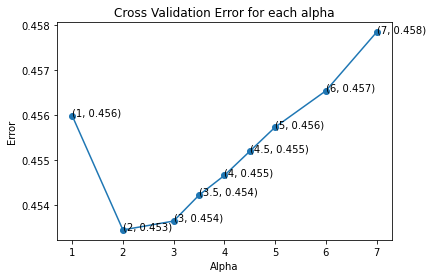

In [60]:
alpha = [1, 2, 3, 3.5, 4, 4.5, 5, 6, 7] 
cv_rmsle_array=[] 
for i in tqdm(alpha):
    model = Ridge(solver="sag", random_state=56, alpha=i)
    model.fit(X_train, y_train)
    preds_cv = model.predict(X_cv)
    cv_rmsle_array.append(sqrt(mse(y_cv, preds_cv)))

for i in range(len(cv_rmsle_array)):
    print ('RMSLE for alpha = ',alpha[i],'is',cv_rmsle_array[i])
    
best_alpha = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_rmsle_array)
ax.scatter(alpha, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_rmsle_array[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

In [61]:
print("Best alpha: ",  alpha[best_alpha])
model = Ridge(solver="sag", random_state=56, alpha=alpha[best_alpha])
model.fit(X_train, y_train)
ridge_preds_tr = model.predict(X_train)
ridge_preds_cv = model.predict(X_cv)
ridge_preds_te = model.predict(X_test)

print('Train RMSLE:', sqrt(mse(y_train, ridge_preds_tr)))

ridge_rmsle = sqrt(mse(y_cv, ridge_preds_cv))
print("Cross validation RMSLE: ", ridge_rmsle)

Best alpha:  2


c:\users\gulec\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


Train RMSLE: 0.3561881456310353
Cross validation RMSLE:  0.45344766215301313


In [62]:
submission_df['price'] = np.exp(ridge_preds_te) - 1

submission_df.to_csv('ridge_submission_2.csv', index=False)

In [69]:
#print("Best alpha: ",  alpha[best_alpha])
model = Ridge(solver="sag", random_state=56, alpha=2.5)
model.fit(X_train, y_train)
ridge_preds_tr = model.predict(X_train)
ridge_preds_cv = model.predict(X_cv)
ridge_preds_te = model.predict(X_test)

print('Train RMSLE:', sqrt(mse(y_train, ridge_preds_tr)))

ridge_rmsle = sqrt(mse(y_cv, ridge_preds_cv))
print("Cross validation RMSLE: ", ridge_rmsle)

c:\users\gulec\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


Train RMSLE: 0.3634728430968471
Cross validation RMSLE:  0.4533832500185018


In [70]:
submission_df['price'] = np.exp(ridge_preds_te) - 1

submission_df.to_csv('ridge_submission_3.csv', index=False)

In [65]:
import scipy
scipy.sparse.save_npz("cv_final.npz", X_cv)
np.save('y_cv', y_cv)

In [66]:
scipy.sparse.save_npz("train_final.npz", X_train)
np.save('y_train', y_train)

In [67]:
scipy.sparse.save_npz("test_final.npz", X_test)

In [68]:
""""
X_train_saved = scipy.sparse.load_npz("train_final.npz")
y_train_saved = np.load('y_train.npy')

X_cv_saved = scipy.sparse.load_npz("cv_final.npz")
y_cv_saved = np.load('y_cv.npy')

X_test_saved = scipy.sparse.load_npz("test_final.npz")
X_train_saved.shape, y_train_saved.shape, X_cv_saved.shape, y_cv_saved.shape, X_test_saved.shape 
"""

((881245, 755184), (881245,), (155514, 755184), (155514,), (444761, 755184))

In [74]:
np.save('ridge_preds_tr', ridge_preds_tr)
np.save('ridge_preds_cv', ridge_preds_cv)
np.save('ridge_preds_te', ridge_preds_te)
np.save('train_sparse',train_sparse) 
np.save('cv_sparse', cv_sparse)
np.save('test_sparse',test_sparse)